In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split


In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size   = 128
learning_rate = 1e-3
num_epochs    = 20
val_split     = 0.1   # 10% of train used for validation


In [3]:
# SVHN images are RGB, so we normalize all three channels
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std =[0.5, 0.5, 0.5]),
])

# Download and load training set
full_train = datasets.SVHN(root="./data",
                          split="train",
                          download=True,
                          transform=transform)

# Split train into train/val
n_val = int(len(full_train) * val_split)
n_train = len(full_train) - n_val
train_ds, val_ds = random_split(full_train, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

# Testing set
test_ds = datasets.SVHN(root="./data",
                       split="test",
                       download=True,
                       transform=transform)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


In [4]:
class SVHNCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),   # 64×64×32
            nn.ReLU(),
            nn.MaxPool2d(2),                  # 32×32×32
            nn.Conv2d(32, 64, 3, padding=1),  # 32×32×64
            nn.ReLU(),
            nn.MaxPool2d(2),                  # 16×16×64
            nn.Conv2d(64, 128, 3, padding=1), # 16×16×128
            nn.ReLU(),
            nn.MaxPool2d(2),                  #  8×8×128
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = SVHNCNN().to(device)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [18]:
best_val_acc = 0.0
train_losses = []
val_accs = []

for epoch in range(1, num_epochs+1):
    # --- Training ---
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    # --- Validation ---
    model.eval()
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_acc = correct / len(val_loader.dataset)
    val_accs.append(val_acc)
    
    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_svhc_cnn.pth")
    
    print(f"Epoch {epoch:02d} — Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 01 — Loss: 0.1737, Val Acc: 0.9094
Epoch 02 — Loss: 0.1694, Val Acc: 0.9122
Epoch 03 — Loss: 0.1632, Val Acc: 0.9139
Epoch 04 — Loss: 0.1568, Val Acc: 0.9100
Epoch 05 — Loss: 0.1466, Val Acc: 0.9115
Epoch 06 — Loss: 0.1421, Val Acc: 0.9113
Epoch 07 — Loss: 0.1422, Val Acc: 0.9091
Epoch 08 — Loss: 0.1302, Val Acc: 0.9128
Epoch 09 — Loss: 0.1314, Val Acc: 0.9145
Epoch 10 — Loss: 0.1200, Val Acc: 0.9124
Epoch 11 — Loss: 0.1232, Val Acc: 0.9104
Epoch 12 — Loss: 0.1157, Val Acc: 0.9096
Epoch 13 — Loss: 0.1132, Val Acc: 0.9107
Epoch 14 — Loss: 0.1100, Val Acc: 0.9125
Epoch 15 — Loss: 0.1074, Val Acc: 0.9109
Epoch 16 — Loss: 0.1006, Val Acc: 0.9063
Epoch 17 — Loss: 0.1009, Val Acc: 0.9117
Epoch 18 — Loss: 0.1001, Val Acc: 0.9115
Epoch 19 — Loss: 0.0976, Val Acc: 0.9117
Epoch 20 — Loss: 0.1001, Val Acc: 0.9114


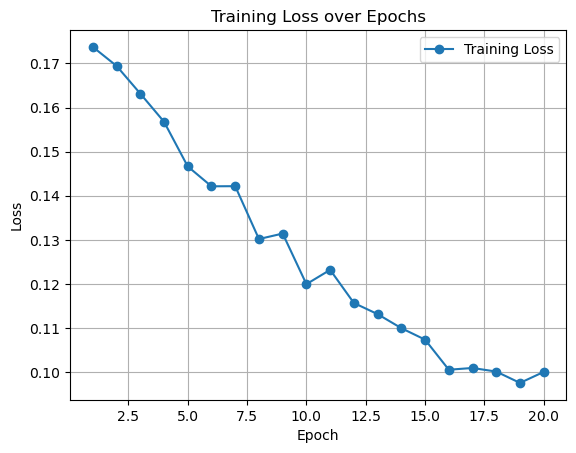

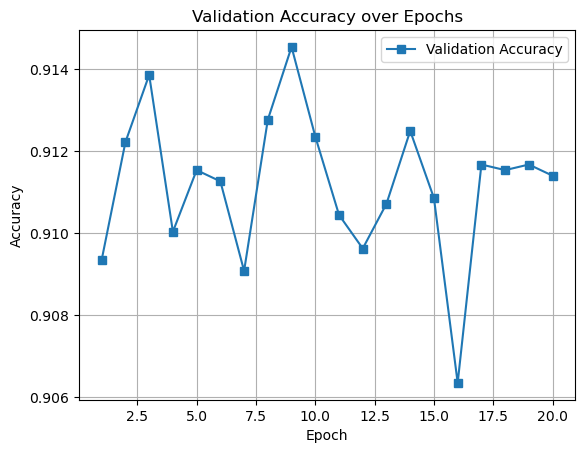

In [19]:
epochs = range(1, num_epochs+1)
plt.figure()
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Validation Accuracy
plt.figure()
plt.plot(epochs, val_accs, marker='s', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Load best model
model.load_state_dict(torch.load("best_svhc_cnn.pth"))
model.eval()

correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs).argmax(dim=1)
        correct += (preds == labels).sum().item()

test_acc = correct / len(test_loader.dataset)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.9017
